In [29]:
# Import Libraries 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import load_model
from tqdm import tqdm
import keras.backend as K
import cv2
from PIL import Image, ImageChops, ImageEnhance, ImageFilter

In [10]:
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]
    
filters = filter1+filter2+filter3

In [11]:
def convert_to_ela_image(image, quality):
    temp_filename = 'temp_file.jpg'
    image = Image.open(image)
    
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [12]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

#IoU Score
def iou_score(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
    
#Load model 
phase1 = load_model("phase1.h5")
phase2 = load_model('phase2.h5', custom_objects={'iou_score': iou_score})

In [13]:
def predict(img_path) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=phase1.predict(pi)

    return predict[0]

In [14]:
def predictRegion(img):
    
    image = np.array(image)
    
    img = cv2.resize(image, (512, 512))
    srm_img = cv2.filter2D(img, -1, filters)
    
    img = np.expand_dims(img, axis=0)
    srm_img = np.expand_dims(srm_img, axis=0)

    prediction = phase2.predict([img, srm_img])

    prediction = prediction.squeeze()

    for i in range(prediction.shape[0]) :
        for j in range(prediction.shape[1]) :
            if prediction[i][j]>0.75 :
                prediction[i][j]=1.0
            else :
                prediction[i][j]=0.0

    return prediction

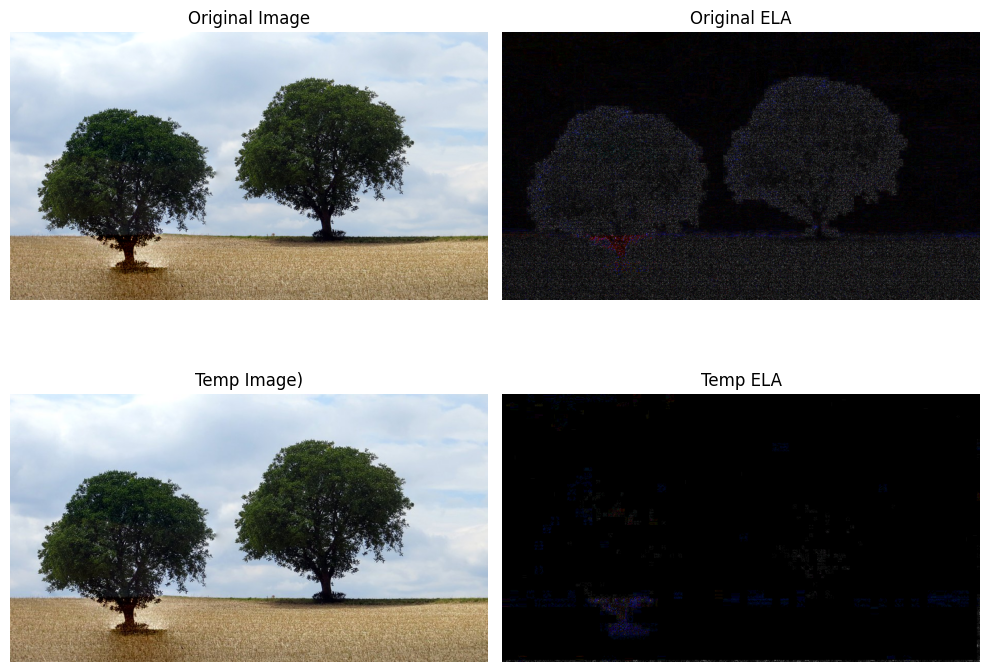

In [26]:
# Jpeg Compression

# Open the original image
img_path = "forged6.png"

original_img = Image.open(img_path)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Original Image
axes[0, 0].imshow(original_img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

ela_original = convert_to_ela_image(img_path,85)
# Original ELA Image
axes[0, 1].imshow(ela_original, cmap='gray')
axes[0, 1].set_title("Original ELA")
axes[0, 1].axis("off")

original_img.save('temp.jpg', 'JPEG',quality=85)
temp_img = Image.open("temp.jpg")
# Temp Image
axes[1, 0].imshow(temp_img)
axes[1, 0].set_title(f"Temp Image)")
axes[1, 0].axis("off")

ela_temp = convert_to_ela_image("temp.jpg",85)
# Temp ELA Image
axes[1, 1].imshow(ela_temp, cmap='gray')
axes[1, 1].set_title(f"Temp ELA")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()



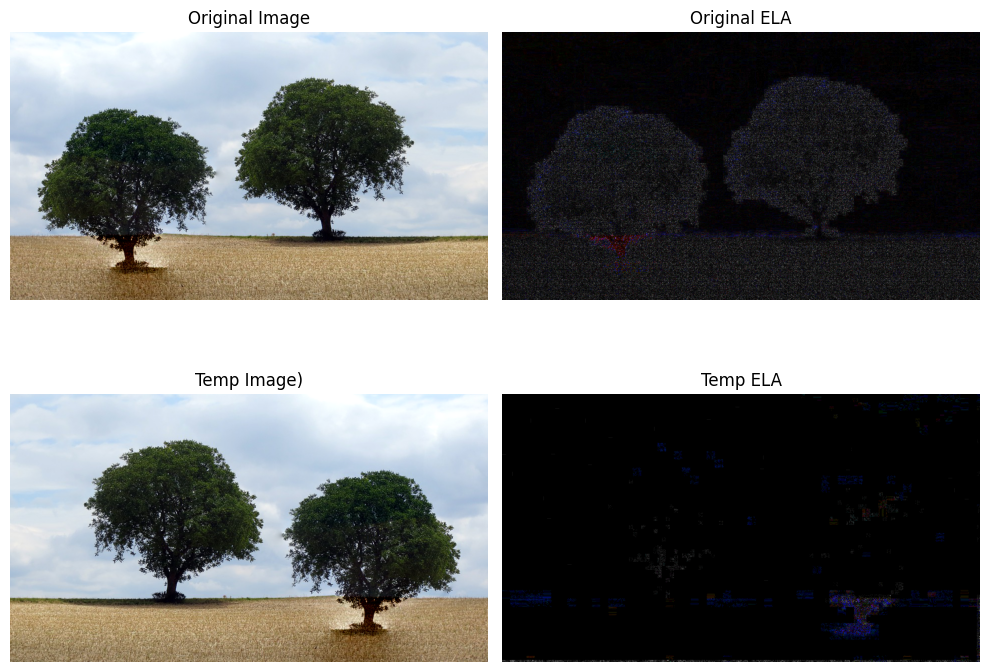

In [27]:
# Flipping

# Open the original image
img_path = "forged6.png"

original_img = Image.open(img_path)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Original Image
axes[0, 0].imshow(original_img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

ela_original = convert_to_ela_image(img_path,85)
# Original ELA Image
axes[0, 1].imshow(ela_original, cmap='gray')
axes[0, 1].set_title("Original ELA")
axes[0, 1].axis("off")

temp_img = original_img.transpose(Image.FLIP_LEFT_RIGHT)
temp_img.save('temp.jpg', 'JPEG',quality=85)
# Temp Image
axes[1, 0].imshow(temp_img)
axes[1, 0].set_title(f"Temp Image)")
axes[1, 0].axis("off")

ela_temp = convert_to_ela_image("temp.jpg",85)
# Temp ELA Image
axes[1, 1].imshow(ela_temp, cmap='gray')
axes[1, 1].set_title(f"Temp ELA")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()



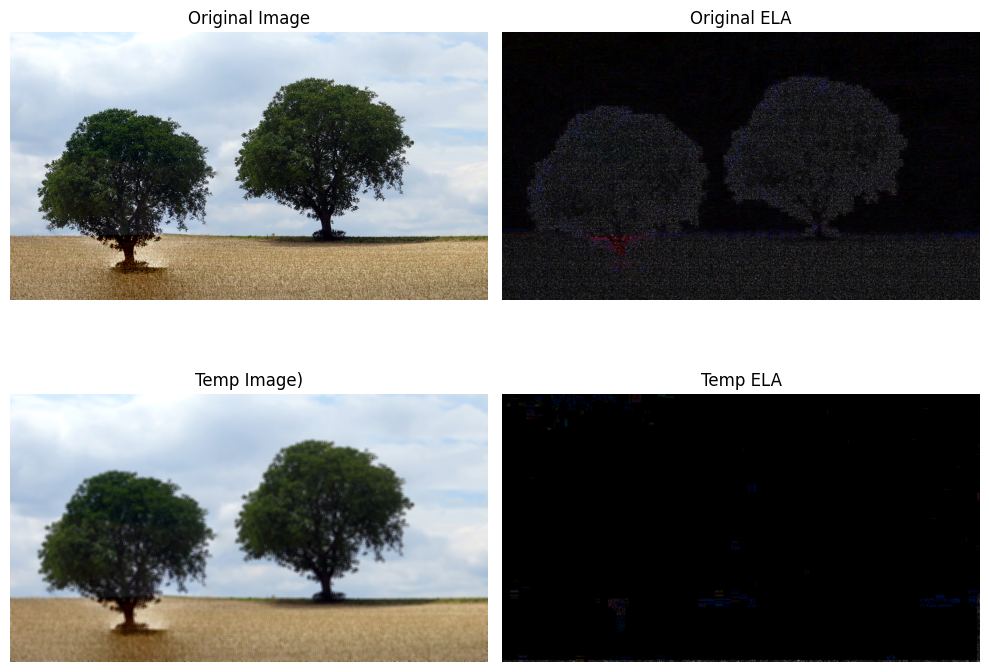

In [30]:
# Image Blurring

# Open the original image
img_path = "forged6.png"

original_img = Image.open(img_path)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Original Image
axes[0, 0].imshow(original_img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

ela_original = convert_to_ela_image(img_path,85)
# Original ELA Image
axes[0, 1].imshow(ela_original, cmap='gray')
axes[0, 1].set_title("Original ELA")
axes[0, 1].axis("off")

temp_img = original_img.filter(ImageFilter.BLUR)
temp_img.save('temp.jpg', 'JPEG',quality=85)
# Temp Image
axes[1, 0].imshow(temp_img)
axes[1, 0].set_title(f"Temp Image")
axes[1, 0].axis("off")

ela_temp = convert_to_ela_image("temp.jpg",85)
# Temp ELA Image
axes[1, 1].imshow(ela_temp, cmap='gray')
axes[1, 1].set_title(f"Temp ELA")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

